In [1]:
#import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.inspection import permutation_importance
import sklearn.metrics as metrics

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [2]:
# Load dicom dataframe
df = pd.read_feather('../../Data/cleaned_dicom_df.feather')

# Get all lines where BodyPart is Ganzkörper and SliceCount is greater than 600
df = df[((df['BodyPart'] == 'Ganzkörper') | (df['BodyPart'] == 'Stamm')) & (df['SliceCount'] > 400)]

df.head()

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,SliceThickness,PixelArrayFile
0,ANONYM-XT8UJZ,64,M,80.0,1.81,Ganzkörper,512,512,487,0.976562,4.0,Scan_1.npy
1,ANONYM-XT8UJZ_1,56,M,73.0,1.71,Stamm,512,512,567,1.171875,3.0,Scan_2.npy
4,ANONYM-XT8UJZ_3,77,F,74.0,1.63,Stamm,512,512,567,1.171875,3.0,Scan_5.npy
6,ANONYM-XT8UJZ_5,76,F,77.0,1.63,Stamm,512,512,568,1.171875,3.0,Scan_7.npy
10,ANONYM-XT8UJZ_9,51,F,67.0,1.72,Stamm,512,512,567,1.171875,3.0,Scan_11.npy


In [3]:
# Cleaning
# drop PatientId
df = df.drop(columns=['PatientId', 'PixelArrayFile', 'BodyPart'])

# make PatientSex to one hot encoding 0:M, 1:F
df['PatientSex'] = df['PatientSex'].apply(lambda x: 0 if x == 'M' else 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 229
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PatientAge      87 non-null     int64  
 1   PatientSex      87 non-null     int64  
 2   PatientWeight   87 non-null     float64
 3   PatientSize     87 non-null     float64
 4   Rows            87 non-null     int64  
 5   Columns         87 non-null     int64  
 6   SliceCount      87 non-null     int64  
 7   PixelSpacing    87 non-null     float64
 8   SliceThickness  87 non-null     float64
dtypes: float64(4), int64(5)
memory usage: 6.8 KB


In [4]:
X = df.drop(columns=['PatientWeight'])
y = df['PatientWeight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# train decision tree model with best parameters
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

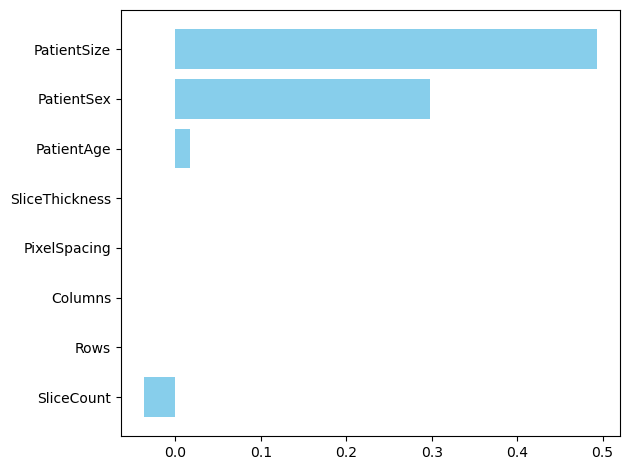

In [6]:
# plot permutation importance
result = permutation_importance(dt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()

ax.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx], color='skyblue')

plt.tight_layout()
 
plt.show()

In [7]:
# extract X_train, X_test only with important features
X_train = X_train[['PatientSize', 'PatientSex', 'PatientAge']]
X_test = X_test[['PatientSize', 'PatientSex', 'PatientAge']]

# train decision tree model with best parameters
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [9]:
# evaluate the model
y_pred = dt.predict(X_test)
# calculate the mean absolute error
mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 14.722222222222221


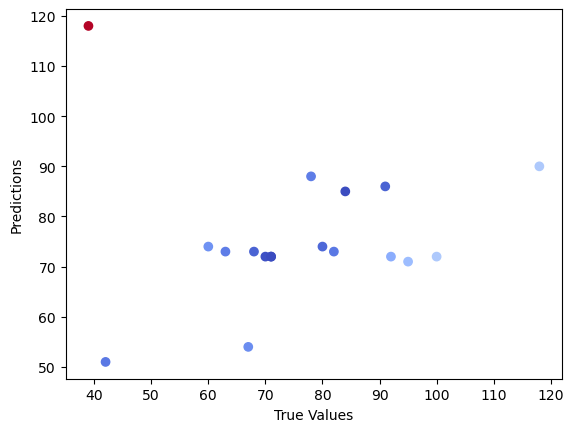

In [10]:
# plot y_test, y_pred. on y axis we have y_test and on x axis we have y_pred
# color each point if it is farer away from the line y=x
plt.scatter(y_test, y_pred, c=np.abs(y_test - y_pred), cmap='coolwarm')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()